In [1]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as con
from tqdm import tqdm

In [2]:
df_h=pd.read_csv('../data/rv/TOI1696_rv_h_new.dat', sep=',')[1:]
df_yj=pd.read_csv('../data/rv/TOI1696_rv_yj_new.dat', sep=',')[1:]
df_h

,bjd,rv,rv_err
1,2.459488e+06,0.079955,0.00817
2,2.459508e+06,0.066788,0.01087
3,2.459508e+06,0.026116,0.00823
4,2.459510e+06,0.062113,0.01018
5,2.459510e+06,-0.001363,0.00854
6,2.459515e+06,-0.001412,0.00939
7,2.459515e+06,-0.029998,0.00843
8,2.459531e+06,-0.074507,0.00947
9,2.459589e+06,0.001363,0.00936


In [3]:
df = df_h

In [4]:
# values from paper
Porb = 2.500311, 0.000004
tc = 2458816.697706, 0.0027523146

In [5]:
def fold_index(time, period, tc=0):
    phase = []
    
    for t in time:
        
        ph = ((t-tc)%period)/period
        if ph > 0.5:
            ph = ph - 1.
            
        phase.append(ph)
        
    idx = np.argsort(phase)
    phase = np.sort(phase)
    
    return phase, idx

In [6]:
df['bjd']

1    2.459488e+06
2    2.459508e+06
3    2.459508e+06
4    2.459510e+06
5    2.459510e+06
6    2.459515e+06
7    2.459515e+06
8    2.459531e+06
9    2.459589e+06
Name: bjd, dtype: float64

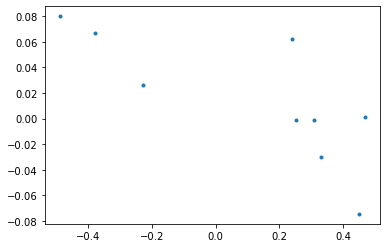

In [7]:
phase_obs, _ = fold_index(df['bjd'], Porb[0], tc[0])

pl.plot(phase_obs, df['rv'], '.')

In [8]:
from astropy import constants as con

In [9]:
def rv_model_K(K, t0, p, tm):  
    rv = -K* np.sin(2 * np.pi / p * (tm-t0)) 
    return rv

def rv_model_K_phase(K, ph):
    rv = -K*np.sin(ph*np.pi*2)
    return rv

def rv_model_M_phase(mp, ph):  
    mp_u = mp * con.M_earth
    ms_u = 0.255 * con.M_sun
    
    #K = (2 * np.pi * con.G / Porb[0])**(1/3.)* mp_u*np.sin(i)/(ms_u+mp_u)**(2/3.)
    K = (2 * np.pi * con.G / Porb[0])**(1/3.)* mp_u/(ms_u+mp_u)**(2/3.)
    
    rv = -K*np.sin(ph*np.pi*2)
    return rv.value/1000

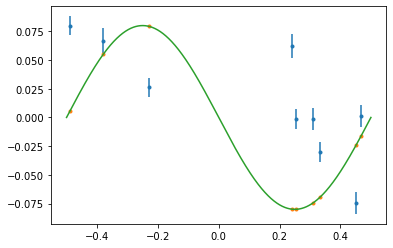

In [14]:
phase_pr = np.linspace(-0.5,0.5,10000)

pl.errorbar(phase_obs, df['rv'], df['rv_err'], fmt='.')
pl.plot(phase_obs, rv_model_K_phase(0.08, phase_obs), '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

In [23]:
def red_chisq(K):
    rv_o = df['rv']
    rv_e = df['rv_err']
    rv_m = rv_model_K_phase(K, phase_obs)
    
    return  np.sum(((rv_o - rv_m)/rv_e)**2) /8.

In [24]:
chisq=red_chisq(0.08)
chisq

64.91448159218811

In [25]:
const = chisq**0.5

In [26]:
np.sum(((df['rv'] - rv_model_K_phase(0.08, phase_obs))/(df['rv_err']*const))**2) /8.

0.9999999999999998

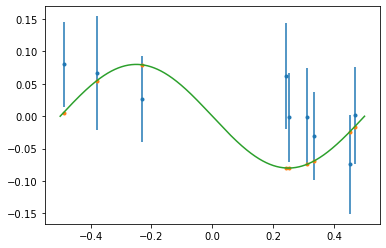

In [27]:
phase_pr = np.linspace(-0.5,0.5,10000)

pl.errorbar(phase_obs, df['rv'], df['rv_err']*const, fmt='.')
pl.plot(phase_obs, rv_model_K_phase(0.08, phase_obs), '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

In [ ]:
def get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=0, inc=np.pi/2):
    """
    """
    P = Porb_samples*u.day.to(u.second)*u.second
    Ms = Ms_samples*u.Msun.to(u.kg)*u.kg
    K = K_samples*(u.m/u.second)
    Mp_samples = ((P*Ms**2)/(2*np.pi*c.G))**(1/3)*(K*(1-e**2)**0.5)/np.sin(inc)
    return Mp_samples

In [44]:
for i,k in zip(pctls,[10, 30, 50]):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(df.bjd, t0, Porb[0], e, w, k, k0)
    
    chisq = np.sum(((rv - df.rv)/(df.rv_err))**2)
    
    const = chisq**0.5
    
    red_chisq = np.sum(((rv - df.rv)/(df.rv_err*const))**2)
    
    print(k, Mp, chisq, red_chisq)

NameError: name 'pctls' is not defined

In [29]:
def logprob(K):
    rv_o = df['rv']
    rv_e = df['rv_err']
    rv_m = rv_model_K_phase(K, phase_obs)
    
    return -0.5 * np.sum(((rv_o - rv_m)/rv_e)**2) 

In [31]:
K=[0.5]

model=rv_model_K_phase(0.08, phase_pr)


In [12]:
import emcee

K=[0.05]

dim = 1
nwalkers = 100
nsteps=1000
pos0 = [K + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, dim, logprob)
sampler.run_mcmc(pos0, nsteps, progress=True)

100%|██████████| 1000/1000 [01:02<00:00, 16.40it/s]


State([[-0.02540408]
 [-0.02344816]
 [-0.03342809]
 [-0.03059407]
 [-0.03196959]
 [-0.01654594]
 [-0.03682775]
 [-0.02245153]
 [-0.04472589]
 [-0.03285478]
 [-0.0308526 ]
 [-0.03702332]
 [-0.04639085]
 [-0.0427667 ]
 [-0.04432539]
 [-0.03576773]
 [-0.02727201]
 [-0.03186029]
 [-0.02318532]
 [-0.0355552 ]
 [-0.02511179]
 [-0.03962838]
 [-0.03559028]
 [-0.03799476]
 [-0.0263018 ]
 [-0.03571851]
 [-0.03071607]
 [-0.03217671]
 [-0.0307531 ]
 [-0.02657644]
 [-0.03791211]
 [-0.02850859]
 [-0.03965809]
 [-0.02334534]
 [-0.03678752]
 [-0.02709058]
 [-0.03297558]
 [-0.03571958]
 [-0.03923064]
 [-0.03928866]
 [-0.03061084]
 [-0.03656458]
 [-0.03446604]
 [-0.03087806]
 [-0.02939547]
 [-0.03903686]
 [-0.03573312]
 [-0.02804024]
 [-0.04297807]
 [-0.03506277]
 [-0.0255284 ]
 [-0.0295641 ]
 [-0.01817554]
 [-0.02915174]
 [-0.03240401]
 [-0.03851304]
 [-0.03356188]
 [-0.0373157 ]
 [-0.02892989]
 [-0.02491647]
 [-0.03879171]
 [-0.03132058]
 [-0.03597251]
 [-0.01734755]
 [-0.03605916]
 [-0.0230325 ]
 [-0

how to add jitter term?

In [51]:
sampler.chain[:,:].shape

(100, 1000, 1)

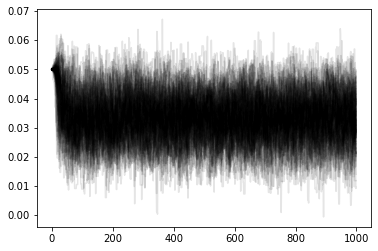

In [52]:
pl.plot(sampler.chain[:,:,0].T, color='k', alpha=0.1)

(array([2.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 7.000e+00, 1.200e+01,
        3.500e+01, 6.700e+01, 1.220e+02, 1.970e+02, 2.970e+02, 4.210e+02,
        6.040e+02, 8.140e+02, 1.158e+03, 1.590e+03, 1.900e+03, 2.495e+03,
        2.780e+03, 3.474e+03, 3.886e+03, 4.398e+03, 4.865e+03, 5.295e+03,
        5.593e+03, 5.386e+03, 5.233e+03, 4.907e+03, 4.657e+03, 4.034e+03,
        3.586e+03, 2.920e+03, 2.477e+03, 1.820e+03, 1.438e+03, 1.068e+03,
        8.470e+02, 5.910e+02, 4.020e+02, 2.570e+02, 1.380e+02, 9.100e+01,
        5.900e+01, 2.600e+01, 2.700e+01, 4.000e+00, 5.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.00055539,  0.0007993 ,  0.00215398,  0.00350866,  0.00486334,
         0.00621802,  0.00757271,  0.00892739,  0.01028207,  0.01163675,
         0.01299143,  0.01434612,  0.0157008 ,  0.01705548,  0.01841016,
         0.01976485,  0.02111953,  0.02247421,  0.02382889,  0.02518357,
         0.02653826,  0.02789294,  0.02924762,  0.0306023 ,  0.03195698,
         0.

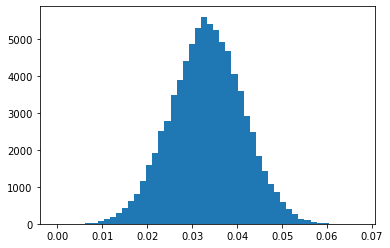

In [53]:
samples=sampler.chain[:,200:, :].reshape(-1)
df_chain= pd.DataFrame(samples)
pl.hist(samples, bins=50)

In [54]:
A,B,C,D,E=np.percentile(df_chain[0], [ 2.5, 16, 50, 84, 97.5], axis=0)
del1l =C-B   #1sigma
del1h=D-C
del2l=C-A   #2sigma
del2h=E-C 

best_K = C
best_K_err1=max(del1l,del1h)
best_K_err2=max(del2l,del2h)

print(best_K, best_K_err1, best_K_err2)

0.03330654255130501 0.008014834149377034 0.015808392810092418


収束判定まだしてないよ！

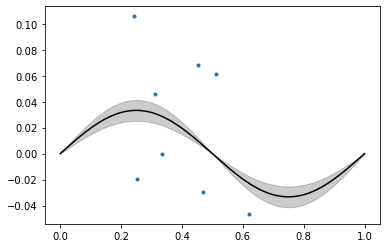

In [55]:
fig, ax = pl.subplots()

ax.plot(phase_obs, df['rv'], '.')

ax.plot(phase_pr, rv_model_K_phase(best_K, phase_pr), '-', color='k')

y1 = rv_model_K_phase(best_K+best_K_err1, phase_pr)
y2 = rv_model_K_phase(best_K-best_K_err1, phase_pr)

ax.fill_between(phase_pr, y1, y2, color='k', alpha=0.2)